In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load the dataset
series = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True).squeeze()

# Convert the series to a DataFrame
df = series.to_frame(name='Passengers')

# Split the data into training and testing sets
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Function to create dataset for supervised learning
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset.iloc[i:(i + time_steps), 0].values)
        y.append(dataset.iloc[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create supervised learning datasets
X_train, y_train = create_dataset(train, time_steps=12)
X_test, y_test = create_dataset(test, time_steps=12)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_original = y_train.copy()
y_test_original = y_test.copy()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
y_test = scaler.transform(y_test.reshape(-1, 1)).reshape(-1,)

# Build the baseline LSTM model
baseline_lstm_model = Sequential()
baseline_lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
baseline_lstm_model.add(Dense(1))
baseline_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the baseline LSTM model
baseline_lstm_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Make predictions on training and validation sets
y_train_pred_baseline = baseline_lstm_model.predict(X_train).reshape(-1, 1)
y_test_pred_baseline = baseline_lstm_model.predict(X_test).reshape(-1, 1)

# Inverse transform the predictions to the original scale
y_train_pred_baseline_original = scaler.inverse_transform(y_train_pred_baseline)
y_test_pred_baseline_original = scaler.inverse_transform(y_test_pred_baseline)

# Print predictions and actual values
print("Predictions on Training Data:")
for i in range(len(y_train_pred_baseline_original)):
    print(f'p {y_train_pred_baseline_original[i][0]} e {y_train_original[i]}')

# Calculate RMSE for training and validation sets
rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_baseline_original))
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred_baseline_original))

# Print RMSE
print(f'RMSE on Training Data (Baseline): {rmse_train}')
print(f'RMSE on Test Data (Baseline): {rmse_test}')
# Save the baseline LSTM model
#save
baseline_lstm_model.save('baseline_lstm_model.keras')



Epoch 1/50

11/11 [==============================] - 7s 8ms/step - loss: 0.1092
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0159
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 6/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0142
Epoch 7/50
11/11 [==============================] - 0s 33ms/step - loss: 0.0137
Epoch 8/50
11/11 [==============================] - 0s 22ms/step - loss: 0.0129
Epoch 9/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0128
Epoch 10/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0137
Epoch 11/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0129
Epoch 12/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0125
Epoch 13/50
11/11 [====================

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

# Function to create an LSTM model
def create_lstm_model(neurons=10):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrapper class for LSTM model compatible with GridSearchCV
class LSTMEstimatorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, neurons=10, epochs=50, batch_size=32):
        self.neurons = neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = create_lstm_model(neurons=self.neurons)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Split the data into training and testing sets
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Function to create dataset for supervised learning
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset.iloc[i:(i + time_steps), 0].values)
        y.append(dataset.iloc[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create supervised learning datasets
X_train, y_train = create_dataset(train, time_steps=12)
X_test, y_test = create_dataset(test, time_steps=12)

# Initialize MinMaxScaler for normalization
scaler_lstm = MinMaxScaler(feature_range=(0, 1))

# Normalize input features (X) for training and testing data
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

# Normalize target variable (y) for training and testing data
y_train_lstm = scaler_lstm.fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
y_test_lstm = scaler_lstm.transform(y_test.reshape(-1, 1)).reshape(-1,)

# Specify the parameters to search
param_grid = {'neurons': [100, 150]}

# Create an instance of the wrapper class
lstm_wrapper = LSTMEstimatorWrapper()

# Use GridSearchCV to find the best parameters
grid = GridSearchCV(estimator=lstm_wrapper, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train_lstm, y_train_lstm)

# Print the best parameters and best score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", -grid_result.best_score_)

# Get the best parameters
best_params = grid_result.best_params_
print(best_params)

# Build the LSTM model with the best parameters
best_lstm_model = create_lstm_model(neurons=best_params['neurons'])

# Train the LSTM model with the best parameters
best_lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=8, verbose=1)

# Make predictions on training and validation sets using the LSTM model
y_train_pred_lstm = best_lstm_model.predict(X_train_lstm)

# Inverse transform the predictions to the original scale
y_train_pred_lstm_original = scaler_lstm.inverse_transform(y_train_pred_lstm)

# Print predictions and actual values for training data
print("Predictions on Training Data (LSTM Model):")
for i in range(len(y_train_pred_lstm_original)):
    print('> Predicted=%.3f, Expected=%.3f' % (y_train_pred_lstm_original[i],y_train[i]))
# Calculate RMSE for training data
rmse_train_lstm = np.sqrt(mean_squared_error(y_train, y_train_pred_lstm_original))
print(f'RMSE on Training Data (LSTM Model): {rmse_train_lstm}')

# Make predictions on validation sets using the LSTM model
y_test_pred_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions to the original scale
y_test_pred_lstm_original = scaler_lstm.inverse_transform(y_test_pred_lstm)

# Print predictions and actual values for validation data
print("Predictions on Test Data (LSTM Model):")
for i in range(len(y_test_pred_lstm_original)):
    print(f'p {y_test_pred_lstm_original[i]} e {y_test[i]}')

# Calculate RMSE for validation data
rmse_test_lstm = np.sqrt(mean_squared_error(y_test, y_test_pred_lstm_original))
print(f'RMSE on Test Data (LSTM Model): {rmse_test_lstm}')

# Save the best LSTM model
best_lstm_model.save('best_lstm_model.keras')

1/1 [==============================] - 2s 2s/step
Best parameters:  {'neurons': 150}
Best score:  0.013047659312532626
{'neurons': 150}
Epoch 1/50
11/11 [==============================] - 8s 23ms/step - loss: 0.0545
Epoch 2/50
11/11 [==============================] - 0s 23ms/step - loss: 0.0191
Epoch 3/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0195
Epoch 4/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0143
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0143
Epoch 6/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0138
Epoch 7/50
11/11 [==============================] - 0s 29ms/step - loss: 0.0134
Epoch 8/50
11/11 [==============================] - 0s 26ms/step - loss: 0.0129
Epoch 9/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0122
Epoch 10/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0163
Epoch 11/50
11/11 [==============================] - 0s 14ms/st

1/1 [==============================] - 0s 134ms/step
Predictions on Test Data (LSTM Model):
p [322.4937] e 340
p [333.5115] e 318
p [350.1968] e 362
p [375.71085] e 348
p [394.4634] e 363
p [419.2986] e 435
p [446.21194] e 491
p [455.99908] e 505
p [437.52722] e 404
p [385.3712] e 359
p [351.22382] e 310
p [332.06866] e 337
RMSE on Test Data (LSTM Model): 29.778428344840794


0
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: 1, dtype: int64
[[360 342 406 396 420 472 548 559 463 407 362 405]
 [342 406 396 420 472 548 559 463 407 362 405 417]
 [406 396 420 472 548 559 463 407 362 405 417 391]
 [396 420 472 548 559 463 407 362 405 417 391 419]
 [420 472 548 559 463 407 362 405 417 391 419 461]
 [472 548 559 463 407 362 405 417 391 419 461 472]
 [548 559 463 407 362 405 417 391 419 461 472 535]
 [559 463 407 362 405 417 391 419 461 472 535 622]
 [463 407 362 405 417 391 419 461 472 535 622 606]
 [407 362 405 417 391 419 461 472 535 622 606 508]
 [362 405 417 391 419 461 472 535 

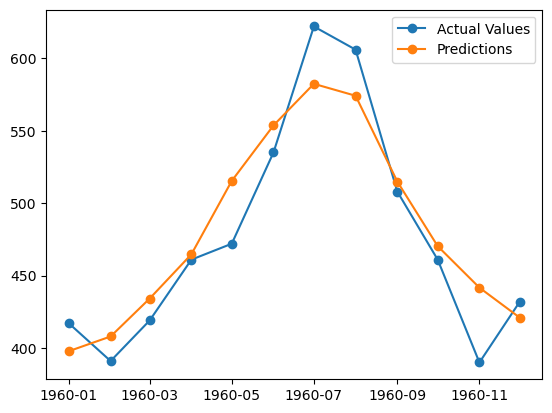

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

def create_dataset(dataset, time_steps=1, target_column=0):
    X, y = [], []
    if isinstance(dataset, pd.Series):
        dataset = dataset.to_frame(name='Passengers')
    for i in range(len(dataset) - time_steps):
        X.append(dataset.iloc[i:(i + time_steps), target_column].values)
        y.append(dataset.iloc[i + time_steps, target_column])
    return np.array(X), np.array(y)

def scale_data(X, y, feature_range=(0, 1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).reshape(-1,)
    return X_scaled, y_scaled, scaler

def inverse_transform_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1,)

# Load the validation series from CSV
validation = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True).squeeze()
print(validation)

# Load the saved advanced model
best_lstm_model = load_model('best_lstm_model.keras')

# Create the dataset for validation
X_val, y_val = create_dataset(validation, time_steps=12)
print(X_val, y_val)

# Scale the data
X_val_scaled, y_val_scaled, scaler = scale_data(X_val, y_val)

# Make predictions on the validation set
predictions = best_lstm_model.predict(X_val_scaled)

# Inverse transform the predictions to get them in the original scale
predictions_original_scale = inverse_transform_predictions(predictions, scaler)
for i in range(len(y_val_scaled)):
    print(f'p {predictions_original_scale[i]} e {y_val[i]}')
# Calculate RMSE for the validation set
rmse = np.sqrt(mean_squared_error(y_val, predictions_original_scale))

# Print RMSE
print(f'RMSE on Validation Data: {rmse}')

# Plot all the actual values
plt.plot(validation.index[12:], y_val, label='Actual Values', marker='o')

# Plot all the predicted values
plt.plot(validation.index[12:], predictions_original_scale, label='Predictions', marker='o')

# Show the plot
plt.legend()
plt.show()